In [1]:
import sys
sys.path.append('..')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".15"
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pathlib import Path
from scipy.interpolate import griddata
import flowrec.training_and_states as state_utils
import flowrec.losses as losses
import utils.simulation2d as project
import flowrec.data as data_utils
import flowrec.physics_and_derivatives as derivatives

import jax
import jax.numpy as jnp
import optax
import haiku as hk

In [2]:
# train_test_split = [70,20,10]
# train_test_split = [600,100,100]
# learning_rate = 0.0001
# mlp_layers = [31] # size of the intermediate layers
# cnn_channels = [31,3]
# cnn_filter = [(3,3)]
# dropout_rate = 0.02
# regularisation_strength = 0.0001
# epochs = 10
# nb_batches = 6
data_dir = Path("./local_data/re100")
# data_dir = Path("/home/ym917/Results/simulations/triangle")

In [7]:
x_base = 132
(ux,uy,pp) = project.read_data(data_dir,x_base)
x = np.stack([ux,uy,pp],axis=0)
# # use only a subset of data for test
x = x[:,:,:250,:]
ux = ux[:,:250,:]
uy = uy[:,:250,:]
pp = pp[:,:250,:]

# [x_train,x_val,x_test], _ = data_utils.data_partition(x,1,train_test_split,REMOVE_MEAN=False,SHUFFLE=False)
# # [x_train,x_val,x_test], [xm_train,xm_val,xm_test] = data_utils.data_partition(x,1,train_test_split,REMOVE_MEAN=True,SHUFFLE=False)

# [ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
# [ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
# [ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))


# triangle_base_coords = [49,80]
# pb_train = project.take_measurement_base(pp_train,ly=triangle_base_coords,centrex=0)
# pb_val = project.take_measurement_base(pp_val,ly=triangle_base_coords,centrex=0)
# pb_test = project.take_measurement_base(pp_test,ly=triangle_base_coords,centrex=0)

# u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
# u_val = np.stack((ux_val,uy_val,pp_val),axis=-1)
# u_test = np.stack((ux_test,uy_test,pp_test),axis=-1)


# (nt,nx,ny) = ux_train.shape
# n_base = pb_train.shape[-1]

# mlp_layers.extend([3*nx*ny])

dx = 12/512
dy = 4/128
dt = 0.0002*625

datainfo = data_utils.DataMetadata(re=100,discretisation=[dt,dx,dy],axis_index=[0,1,2],problem_2d=True)


In [63]:
ux[0,...].size

32250

In [60]:
print(dx,dy,dt)

0.0234375 0.03125 0.125


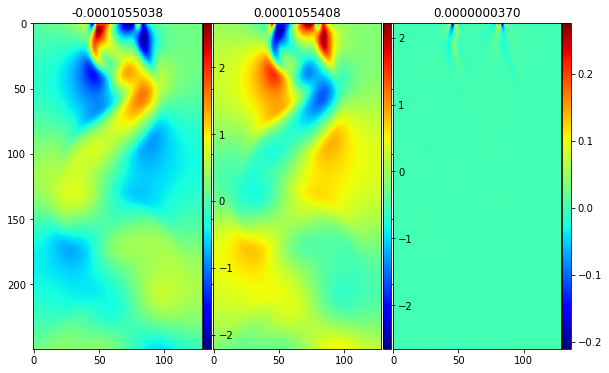

In [59]:
dudx = np.gradient(ux,datainfo.dx,axis=datainfo.axx)
dvdy = np.gradient(uy,datainfo.dy,axis=datainfo.axy)
fig = plt.figure(figsize=(15,6))
grid = ImageGrid(fig,111,(1,3),cbar_mode='each')
for ax,cax,data in zip(grid.axes_all,grid.cbar_axes,[dudx,dvdy,dudx+dvdy]):
    im = ax.imshow(data[100,...],'jet')
    cax.colorbar(im)
    avg = np.mean(data)
    ax.set_title(f'{avg:.10f}')
plt.show()

In [31]:
dudt = jnp.gradient(ux,datainfo.dt,axis=datainfo.axt)

dudx = jnp.gradient(ux,datainfo.dx,axis=datainfo.axx)
d2udx2 = jnp.gradient(dudx,datainfo.dx,axis=datainfo.axx)
ux_dudx = ux*dudx

dudy = jnp.gradient(ux,datainfo.dy,axis=datainfo.axy)
d2udy2 = jnp.gradient(dudy,datainfo.dy,axis=datainfo.axy)
uy_dudy = uy*dudy

dpdx = jnp.gradient(pp,dx,axis=datainfo.axx)

residue = dudt + ux_dudx + uy_dudy + dpdx - (d2udx2 + d2udy2)/datainfo.re

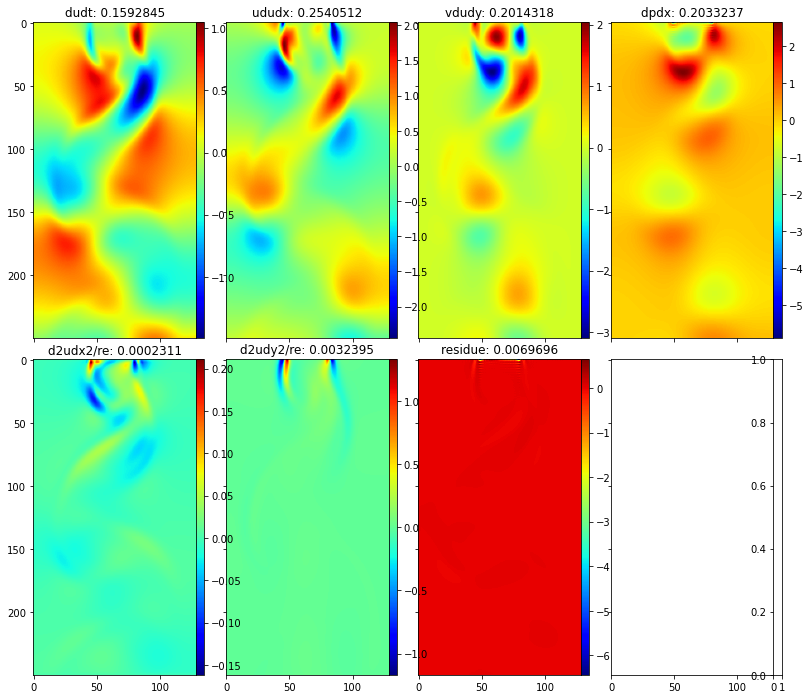

In [68]:
data_list = [dudt, ux_dudx, uy_dudy, dpdx, d2udx2/datainfo.re, d2udy2/datainfo.re, residue]
data_name = ['dudt','ududx', 'vdudy', 'dpdx', 'd2udx2/re', 'd2udy2/re', 'residue']
fig1 = plt.figure(30,figsize=(20,12))
grid = ImageGrid(fig1,111,(2,4),cbar_mode='each',axes_pad=0.3,cbar_pad=0.0)
for i, (ax, cax) in enumerate(zip(grid.axes_all[:7], grid.cbar_axes[:7])):
    im = ax.imshow(data_list[i][100,...],'jet')
    cax.colorbar(im)
    avg = np.mean(data_list[i]**2)
    ax.set_title(f'{data_name[i]}: {avg:.7f}')

plt.show()

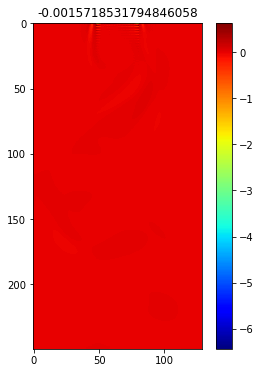

In [57]:
data_plt = (ux_dudx + uy_dudy + dpdx + dudt - d2udx2/datainfo.re - d2udy2/datainfo.re)
fig = plt.figure(figsize=(5,6))
plt.imshow(data_plt[100,...],'jet')
plt.colorbar()
plt.title(f'{np.mean(data_plt)}')
plt.show()

In [67]:
dt**2**2 + 3*dx**2**2 + 2*dy**2**2 + dt**2**2 + 2*dx**2**2 + 3*dy**2**2

0.0004945583641529083